# Librerías 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

C:\Users\Melissa\anaconda3\envs\ptl_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
import numpy as np

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

# Visualización de datos

In [6]:
ds = tfds.load('fashion_mnist', split='train')
dataiterator = ds.as_numpy_iterator()

In [7]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

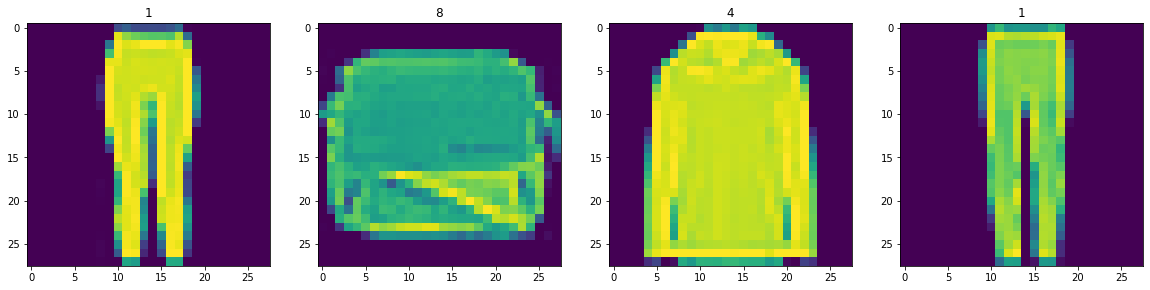

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])    

In [9]:
def scale_images(data):
    image = data['image']
    return image/255

In [10]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

# Neural Network

In [11]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [12]:
generator = build_generator()

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [14]:
img = generator.predict(np.random.randn(4,128,1))

In [15]:
img.shape

(4, 28, 28, 1)

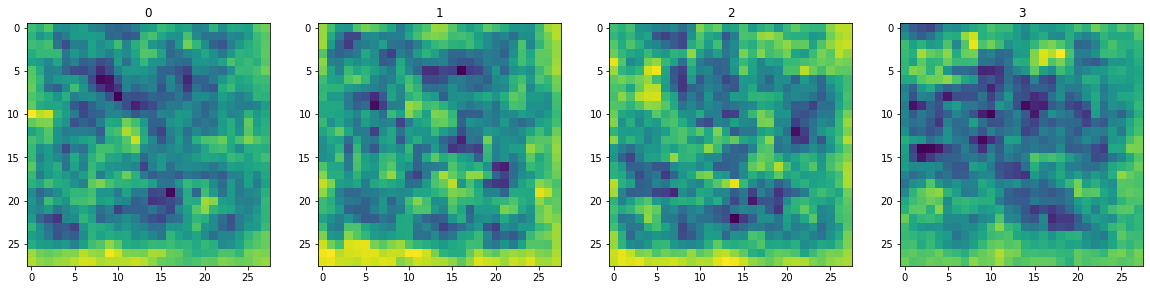

In [16]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)    

In [17]:
def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [18]:
discriminator = build_discriminator()

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
img = generator.predict(np.random.randn(4,128,1))

In [21]:
discriminator.predict(img)

array([[0.49527404],
       [0.4952566 ],
       [0.49534068],
       [0.4951285 ]], dtype=float32)

# Entrenamiento

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
g_opt =  Adam(learning_rate=0.0001)
d_opt =  Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [24]:
from tensorflow.keras.models import Model

In [25]:
tf.random.normal((6,128,1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 7.58985877e-01],
        [-1.05598712e+00],
        [ 4.43289429e-01],
        [-7.35618174e-01],
        [-9.03842971e-02],
        [-4.76548940e-01],
        [-2.01126918e-01],
        [ 5.68651140e-01],
        [-3.27935636e-01],
        [ 4.18837965e-02],
        [ 7.87473738e-01],
        [ 7.17684805e-01],
        [-1.71255827e-01],
        [ 5.91384888e-01],
        [-8.24151993e-01],
        [-1.18187916e+00],
        [ 9.36696351e-01],
        [-1.09821105e+00],
        [-1.95571363e-01],
        [-1.09174025e+00],
        [ 1.01697659e+00],
        [-8.40025187e-01],
        [-8.75178650e-02],
        [ 6.92433417e-01],
        [ 9.40707386e-01],
        [-1.06455803e+00],
        [ 1.13174748e+00],
        [ 6.63077757e-02],
        [-4.82748300e-01],
        [ 1.86761051e-01],
        [-5.08242905e-01],
        [-7.11143762e-02],
        [-1.00069177e+00],
        [-7.77211040e-02],
        [ 2.80882382e+00],
  

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np

In [27]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
    
        super().__init__(*args, **kwargs)
        
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 

        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):

        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        with tf.GradientTape() as d_tape: 

            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
  
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
   
        with tf.GradientTape() as g_tape: 

            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [28]:
fashgan = FashionGAN(generator, discriminator)

In [29]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [30]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [31]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images += 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))
            

In [32]:
hist = fashgan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10
469/469 [==============================] - 106s 216ms/step - d_loss: 0.5022 - g_loss: 1.0865
Epoch 2/10
469/469 [==============================] - 102s 218ms/step - d_loss: 0.3300 - g_loss: 7.0030
Epoch 3/10
469/469 [==============================] - 103s 219ms/step - d_loss: 0.4384 - g_loss: 5.6033
Epoch 4/10
469/469 [==============================] - 104s 221ms/step - d_loss: 0.6818 - g_loss: 0.6642
Epoch 5/10
469/469 [==============================] - 104s 222ms/step - d_loss: 0.6015 - g_loss: 0.4834
Epoch 6/10
469/469 [==============================] - 105s 224ms/step - d_loss: 0.3668 - g_loss: 0.0625
Epoch 7/10
469/469 [==============================] - 105s 225ms/step - d_loss: 0.3169 - g_loss: 0.0391
Epoch 8/10
469/469 [==============================] - 107s 227ms/step - d_loss: 0.5365 - g_loss: 0.1998
Epoch 9/10
469/469 [==============================] - 106s 227ms/step - d_loss: 0.3947 - g_loss: 2.0133
Epoch 10/10
469/469 [==============================] - 106s 227m

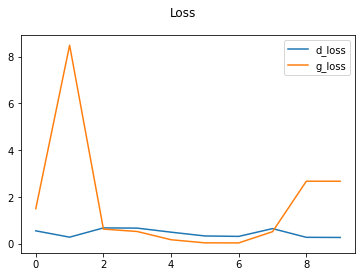

In [34]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [35]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [36]:
generator.load_weights(os.path.join('generator.h5'))

In [37]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

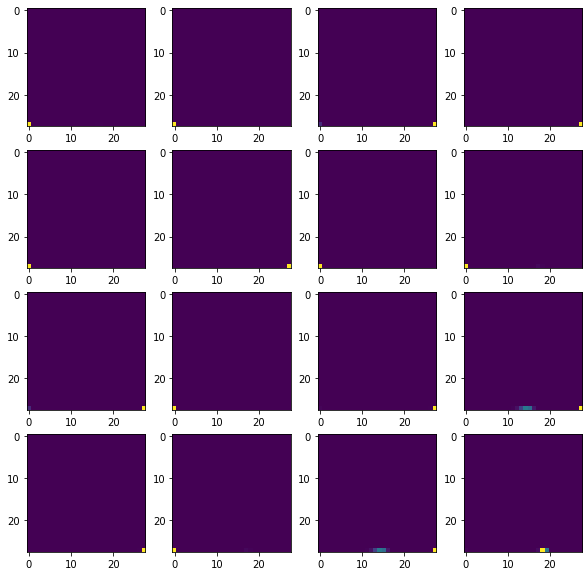

In [38]:

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [40]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')